In [2]:
import os
import errno
import numpy as np 
import deepcell
from deepcell_toolbox.processing import phase_preprocess

In [2]:
# create folder for this set of experiments
experiment_folder = "20200227_IF_Training"
MODEL_DIR = os.path.join("/data/models", experiment_folder)
NPZ_DIR = "/data/npz_data/"
LOG_DIR = '/data/logs'

if not os.path.isdir(MODEL_DIR):
    os.makedirs(MODEL_DIR)

In [5]:
npz1 = np.load(NPZ_DIR + '20200524_IF_Training_8_copy.npz')
# npz2 = np.load(NPZ_DIR + 'Eliot_20200514_256x256_stride_0.5.npz')
# npz1 = np.load(NPZ_DIR + 'cHL_256x256_stride_0.5.npz')
npz2 = np.load(NPZ_DIR + 'CyCIF_256x256_stride_0.5_copy.npz')
npz3 = np.load(NPZ_DIR + '20200518_christine_CyCIF_256_0.5.npz')
#npz2 = np.load(NPZ_DIR + '20200518_christine_CyCIF_256_0.5.npz')

In [6]:
combined_x = np.concatenate((npz1['X'], npz2['X'], npz3['X']), axis=0)
combined_y = np.concatenate((npz1['y'], npz2['y'], npz3['y']), axis=0)

#np.savez(NPZ_DIR + '20200514_IF_Training_8.npz', X=combined_x, y=combined_y)
np.savez(NPZ_DIR + '20200524_IF_Training_9.npz', X=combined_x, y=combined_y)

In [7]:
combined_x.shape

(3158, 256, 256, 2)

In [3]:
from deepcell.utils.data_utils import get_data
from skimage.segmentation import relabel_sequential

npz_name = "20200514_IF_Training_8"
npz_name = "20200521_IF_Training_256"
npz_name = "20200611_all_data"

test_size=0.1
seed=0
DATA_FILE = NPZ_DIR + npz_name + ".npz"
train_dict, val_dict = get_data(DATA_FILE, test_size=test_size, seed=seed)
X_train, y_train = train_dict['X'], train_dict['y']
X_val, y_val = val_dict['X'], val_dict['y']

X.shape: (4510, 256, 256, 2)
y.shape: (4510, 256, 256, 1)
[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47. 48. 49. 50. 51. 52. 53.
 54. 55. 56. 57. 58. 59. 60. 61. 62. 63. 64. 65. 66. 67. 68. 69. 70. 71.
 72. 73. 74. 75. 76. 77. 78.]


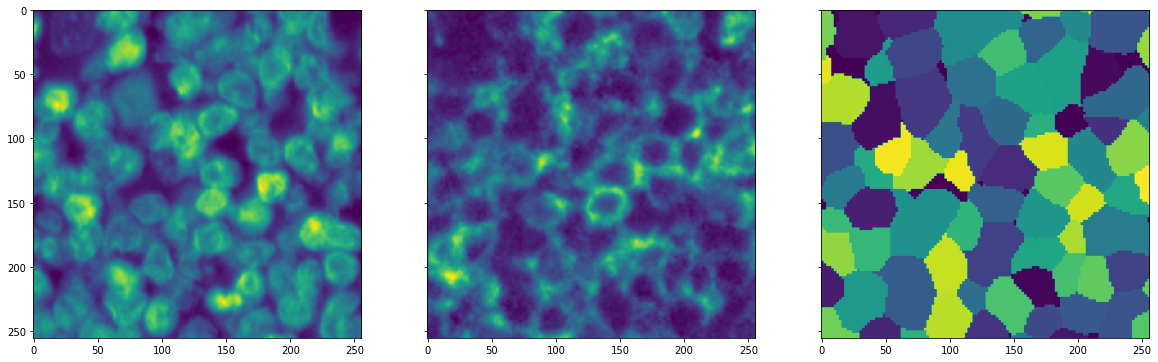

In [5]:
for i in range(y_train.shape[0]):
        y_train[i], _, _ = relabel_sequential(y_train[i])
        
for i in range(y_val.shape[0]):
        y_val[i], _, _ = relabel_sequential(y_val[i])
        
               
print('X.shape: {}\ny.shape: {}'.format(X_train.shape, y_train.shape))
import matplotlib.pyplot as plt
fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(20, 20), sharex=True, sharey=True)

idx = 103
axes[0].imshow(X_train[idx,:,:,0])
axes[1].imshow(X_train[idx,:,:,1])
axes[2].imshow(y_train[idx,:,:,0])
print(np.unique(y_train[idx]))

In [6]:
k=128
for i in range(X_train.shape[0]):
    X = X_train[i,...,0]
    X = rescale_intensity(X, out_range='float')
    X = equalize_adapthist(X, kernel_size=[k,k])
    X_train[i,...,0] = X
    
    X = X_train[i,...,1]
    X = rescale_intensity(X, out_range='float')
    X = equalize_adapthist(X, kernel_size=[k,k])
    X_train[i,...,1] = X
    

for i in range(X_val.shape[0]):
    X = X_val[i,...,0]
    X = rescale_intensity(X, out_range='float')
    X = equalize_adapthist(X, kernel_size=[k,k])
    X_val[i,...,0] = X
    
    X = X_val[i,...,1]
    X = rescale_intensity(X, out_range='float')
    X = equalize_adapthist(X, kernel_size=[k,k])
    X_val[i,...,1] = X

In [139]:
from deepcell.model_zoo.panopticnet import PanopticNet

model = PanopticNet(
    backbone='resnet50',
    input_shape=(256, 256, 2),
    norm_method=None,
    num_semantic_heads=4,
    num_semantic_classes=[1, 1, 2, 3], # inner distance, outer distance, fgbg, pixelwise
    location=True,  # should always be true
    include_top=True)

In [8]:
from tensorflow.keras.optimizers import SGD, Adam
from deepcell.utils.train_utils import rate_scheduler

model_name = npz_name + '_deep_watershed_lr_adapthist_norm'

n_epoch = 45  # Number of training epochs
test_size = .10  # % of data saved as test

optimizer = Adam(lr=1e-4, clipnorm=0.001)
lr_sched = rate_scheduler(lr=1e-4, decay=0.99)

batch_size = 8

min_objects = 3  # throw out images with fewer than this many objects
seed=0
model_name

'20200611_all_data_deep_watershed_lr_adapthist_norm'

In [10]:
from deepcell import image_generators
from deepcell.utils import train_utils


# use augmentation for training but not validation
datagen = image_generators.SemanticDataGenerator(
    rotation_range=180,
    shear_range=0,
    zoom_range=(0.75, 1.25),
    horizontal_flip=True,
    vertical_flip=True)

datagen_val = image_generators.SemanticDataGenerator(
    rotation_range=0,
    shear_range=0,
    zoom_range=0,
    horizontal_flip=0,
    vertical_flip=0)
    
train_data = datagen.flow(
    {'X': X_train, 'y': y_train},
    seed=seed,
    transforms=['inner-distance', 'watershed-cont', 'fgbg', 'pixelwise'],
    transforms_kwargs={'watershed-cont': {'erosion_width': 2}, 'pixelwise':{'dilation_radius': 1}, 
                      'inner-distance': {'erosion_width': 2}},
    min_objects=min_objects,
    batch_size=batch_size)

val_data = datagen_val.flow(
    {'X': X_val, 'y': y_val},
    seed=seed,
    transforms=['inner-distance', 'watershed-cont', 'fgbg', 'pixelwise'],
    transforms_kwargs={'watershed-cont': {'erosion_width': 2}, 'pixelwise':{'dilation_radius': 1},
                      'inner-distance': {'erosion_width': 2}},
    min_objects=min_objects,
    batch_size=batch_size)

W0612 13:59:58.286814 140037308495680 semantic.py:154] Removing 180 of 4510 images with fewer than 3 objects.


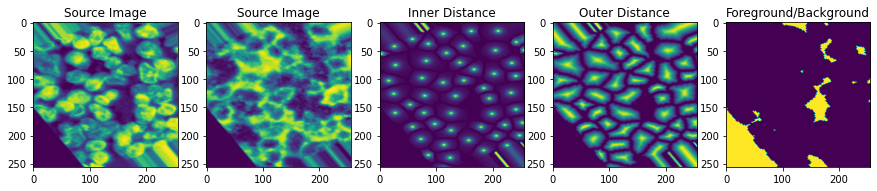

In [12]:
from matplotlib import pyplot as plt

inputs, outputs = train_data.next()

img = inputs[0]
inner_distance = outputs[0]
outer_distance = outputs[1]
fgbg = outputs[2]
#pixelwise = outputs[3]

fig, axes = plt.subplots(1, 5, figsize=(15, 15))

axes[0].imshow(img[:, :, 0])
axes[0].set_title('Source Image')

axes[1].imshow(img[:, :, 1])
axes[1].set_title('Source Image')

axes[2].imshow(inner_distance[0, ..., 0])
axes[2].set_title('Inner Distance')

axes[3].imshow(outer_distance[0, ..., 0])
axes[3].set_title('Outer Distance')

axes[4].imshow(fgbg[0, ..., 0])
axes[4].set_title('Foreground/Background')

plt.show()

In [13]:
# Create a dictionary of losses for each semantic head
from tensorflow.python.keras.losses import MSE
from deepcell import losses


def semantic_loss(n_classes):
    def _semantic_loss(y_pred, y_true):
        if n_classes > 1:
            return 0.01 * losses.weighted_categorical_crossentropy(
                y_pred, y_true, n_classes=n_classes)
        return MSE(y_pred, y_true)
    return _semantic_loss


loss = {}

# Give losses for all of the semantic heads
for layer in model.layers:
    if layer.name.startswith('semantic_'):
        n_classes = layer.output_shape[-1]
        loss[layer.name] = semantic_loss(n_classes)

In [14]:
model.compile(loss=loss, optimizer=optimizer)

In [15]:
from deepcell.utils.train_utils import get_callbacks
from deepcell.utils.train_utils import count_gpus


model_path = os.path.join(MODEL_DIR, '{}.h5'.format(model_name))
loss_path = os.path.join(MODEL_DIR, '{}.npz'.format(model_name))

num_gpus = count_gpus()

print('Training on', num_gpus, 'GPUs.')

train_callbacks = get_callbacks(
    model_path,
    lr_sched=lr_sched,
    tensorboard_log_dir=LOG_DIR,
    save_weights_only=num_gpus >= 2,
    monitor='val_loss',
    verbose=1)

loss_history = model.fit_generator(
    train_data,
    steps_per_epoch=train_data.y.shape[0] // batch_size,
    epochs=n_epoch,
    validation_data=val_data,
    validation_steps=val_data.y.shape[0] // batch_size,
    callbacks=train_callbacks)

Training on 1 GPUs.
Epoch 1/45


W0612 14:00:42.990090 140037308495680 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


  1/541 [..............................] - ETA: 6:00:05 - loss: 0.4493 - semantic_0_loss: 0.2491 - semantic_1_loss: 0.1776 - semantic_2_loss: 0.0084 - semantic_3_loss: 0.0142

W0612 14:01:23.072214 140037308495680 callbacks.py:257] Method (on_train_batch_end) is slow compared to the batch update (0.426729). Check your callbacks.


  2/541 [..............................] - ETA: 3:02:02 - loss: 0.4069 - semantic_0_loss: 0.2274 - semantic_1_loss: 0.1570 - semantic_2_loss: 0.0084 - semantic_3_loss: 0.0141

W0612 14:01:23.260892 140037308495680 callbacks.py:257] Method (on_train_batch_end) is slow compared to the batch update (0.264596). Check your callbacks.


540/541 [============================>.] - ETA: 0s - loss: 0.0703 - semantic_0_loss: 0.0178 - semantic_1_loss: 0.0426 - semantic_2_loss: 0.0031 - semantic_3_loss: 0.0069
Epoch 00001: val_loss improved from inf to 0.13388, saving model to /data/models/20200227_IF_Training/20200611_all_data_deep_watershed_lr_adapthist_norm.h5
541/541 [==============================] - 238s 440ms/step - loss: 0.0702 - semantic_0_loss: 0.0178 - semantic_1_loss: 0.0425 - semantic_2_loss: 0.0031 - semantic_3_loss: 0.0069 - val_loss: 0.1339 - val_semantic_0_loss: 0.0273 - val_semantic_1_loss: 0.0756 - val_semantic_2_loss: 0.0119 - val_semantic_3_loss: 0.0191
Epoch 2/45
540/541 [============================>.] - ETA: 0s - loss: 0.0516 - semantic_0_loss: 0.0130 - semantic_1_loss: 0.0305 - semantic_2_loss: 0.0024 - semantic_3_loss: 0.0057
Epoch 00002: val_loss improved from 0.13388 to 0.05093, saving model to /data/models/20200227_IF_Training/20200611_all_data_deep_watershed_lr_adapthist_norm.h5
541/541 [=======

Epoch 14/45
540/541 [============================>.] - ETA: 0s - loss: 0.0407 - semantic_0_loss: 0.0102 - semantic_1_loss: 0.0237 - semantic_2_loss: 0.0019 - semantic_3_loss: 0.0049
Epoch 00014: val_loss did not improve from 0.03896
541/541 [==============================] - 158s 292ms/step - loss: 0.0407 - semantic_0_loss: 0.0102 - semantic_1_loss: 0.0237 - semantic_2_loss: 0.0019 - semantic_3_loss: 0.0049 - val_loss: 0.0390 - val_semantic_0_loss: 0.0106 - val_semantic_1_loss: 0.0211 - val_semantic_2_loss: 0.0022 - val_semantic_3_loss: 0.0050
Epoch 15/45
540/541 [============================>.] - ETA: 0s - loss: 0.0406 - semantic_0_loss: 0.0102 - semantic_1_loss: 0.0237 - semantic_2_loss: 0.0018 - semantic_3_loss: 0.0049
Epoch 00015: val_loss did not improve from 0.03896
541/541 [==============================] - 158s 291ms/step - loss: 0.0406 - semantic_0_loss: 0.0102 - semantic_1_loss: 0.0237 - semantic_2_loss: 0.0018 - semantic_3_loss: 0.0049 - val_loss: 0.0394 - val_semantic_0_los

Epoch 42/45
540/541 [============================>.] - ETA: 0s - loss: 0.0371 - semantic_0_loss: 0.0093 - semantic_1_loss: 0.0214 - semantic_2_loss: 0.0017 - semantic_3_loss: 0.0046
Epoch 00042: val_loss improved from 0.03630 to 0.03607, saving model to /data/models/20200227_IF_Training/20200611_all_data_deep_watershed_lr_adapthist_norm.h5
541/541 [==============================] - 158s 292ms/step - loss: 0.0371 - semantic_0_loss: 0.0093 - semantic_1_loss: 0.0214 - semantic_2_loss: 0.0017 - semantic_3_loss: 0.0046 - val_loss: 0.0361 - val_semantic_0_loss: 0.0101 - val_semantic_1_loss: 0.0195 - val_semantic_2_loss: 0.0019 - val_semantic_3_loss: 0.0046
Epoch 43/45
540/541 [============================>.] - ETA: 0s - loss: 0.0370 - semantic_0_loss: 0.0094 - semantic_1_loss: 0.0214 - semantic_2_loss: 0.0017 - semantic_3_loss: 0.0046
Epoch 00043: val_loss did not improve from 0.03607
541/541 [==============================] - 155s 287ms/step - loss: 0.0370 - semantic_0_loss: 0.0094 - semant

In [143]:
test_data = np.load('/data/segmentation/datasets/20200610_test_freeze/MIBI_DCIS_test_data.npz')
X_test, y_test = test_data['X'], test_data['y']
X_test_crop, y_test_crop = X_test[:, 256:, 256:, :2], y_test[:, 256:, 256:, :]

In [145]:
from deepcell_toolbox.processing import phase_preprocess
X_test_crop_adjusted = phase_preprocess(X_test_crop)

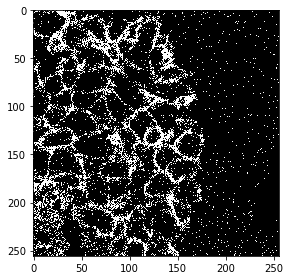

In [155]:
io.imshow(X_test_crop_adjusted[0, :, :, 1] > 0.1)

In [105]:
# from deepcell.applications import MultiplexSegmentation
# app = MultiplexSegmentation(use_pretrained_weights=False)
# # app.model.load_weights(os.path.join(MODEL_DIR, model_name + '.h5'))
# app.model.load_weights('/data/models/20200610_param_tuning/20200612_all_data_512x512_deep_watershed_all_params.h5')
# model.load_weights('/data/models/20200610_param_tuning/20200612_all_data_512x512_deep_watershed_all_params.h5')

In [147]:
from deepcell_toolbox.deep_watershed import deep_watershed_mibi
#inner_distance, outer_distance, fgbg, pixelwise = app._run_model(X_test_adjusted[:, :, :, :2])
inner_distance, outer_distance, fgbg, pixelwise = model.predict(X_test_crop_adjusted)
labeled_images = deep_watershed_mibi([inner_distance, outer_distance, fgbg, pixelwise])

In [120]:
from skimage.exposure import rescale_intensity
from skimage.segmentation import find_boundaries
import copy
def make_color_overlay(input_data):
    """Create a color overlay from 2 channel image data
    
    Args:
        input_data: stack of input images
    
    Returns:
        numpy.array: color-adjusted stack of overlays in RGB mode
    """
    RGB_data = np.zeros(input_data.shape[:3] + (3, ), dtype='float32')
    
    # rescale channels to aid plotting
    for img in range(input_data.shape[0]):
        for channel in range(input_data.shape[-1]):
            # get histogram for non-zero pixels
            percentiles = np.percentile(input_data[img, :, :, channel][input_data[img, :, :, channel] > 0],
                                            [5, 95])
            rescaled_intensity = rescale_intensity(input_data[img, :, :, channel],
                                                       in_range=(percentiles[0], percentiles[1]),
                                                       out_range='float32')
            RGB_data[img, :, :, channel + 1] = rescaled_intensity
        
    # create a blank array for red channel
    return RGB_data

def make_outline_overlay(RGB_data, predictions):
    boundaries = np.zeros_like(predictions)
    overlay_data = copy.copy(RGB_data)
    
    for img in range(predictions.shape[0]):
        boundary = find_boundaries(predictions[img], connectivity=1, mode='inner')
        boundaries[img, boundary > 0] = 1

    overlay_data[boundaries > 0, :] = 1
    
    return overlay_data

In [148]:
RGB_data = make_color_overlay(X_test_crop)
predicted_overlay = make_outline_overlay(RGB_data, labeled_images)
true_overlay = make_outline_overlay(RGB_data, y_test_crop[..., 0])

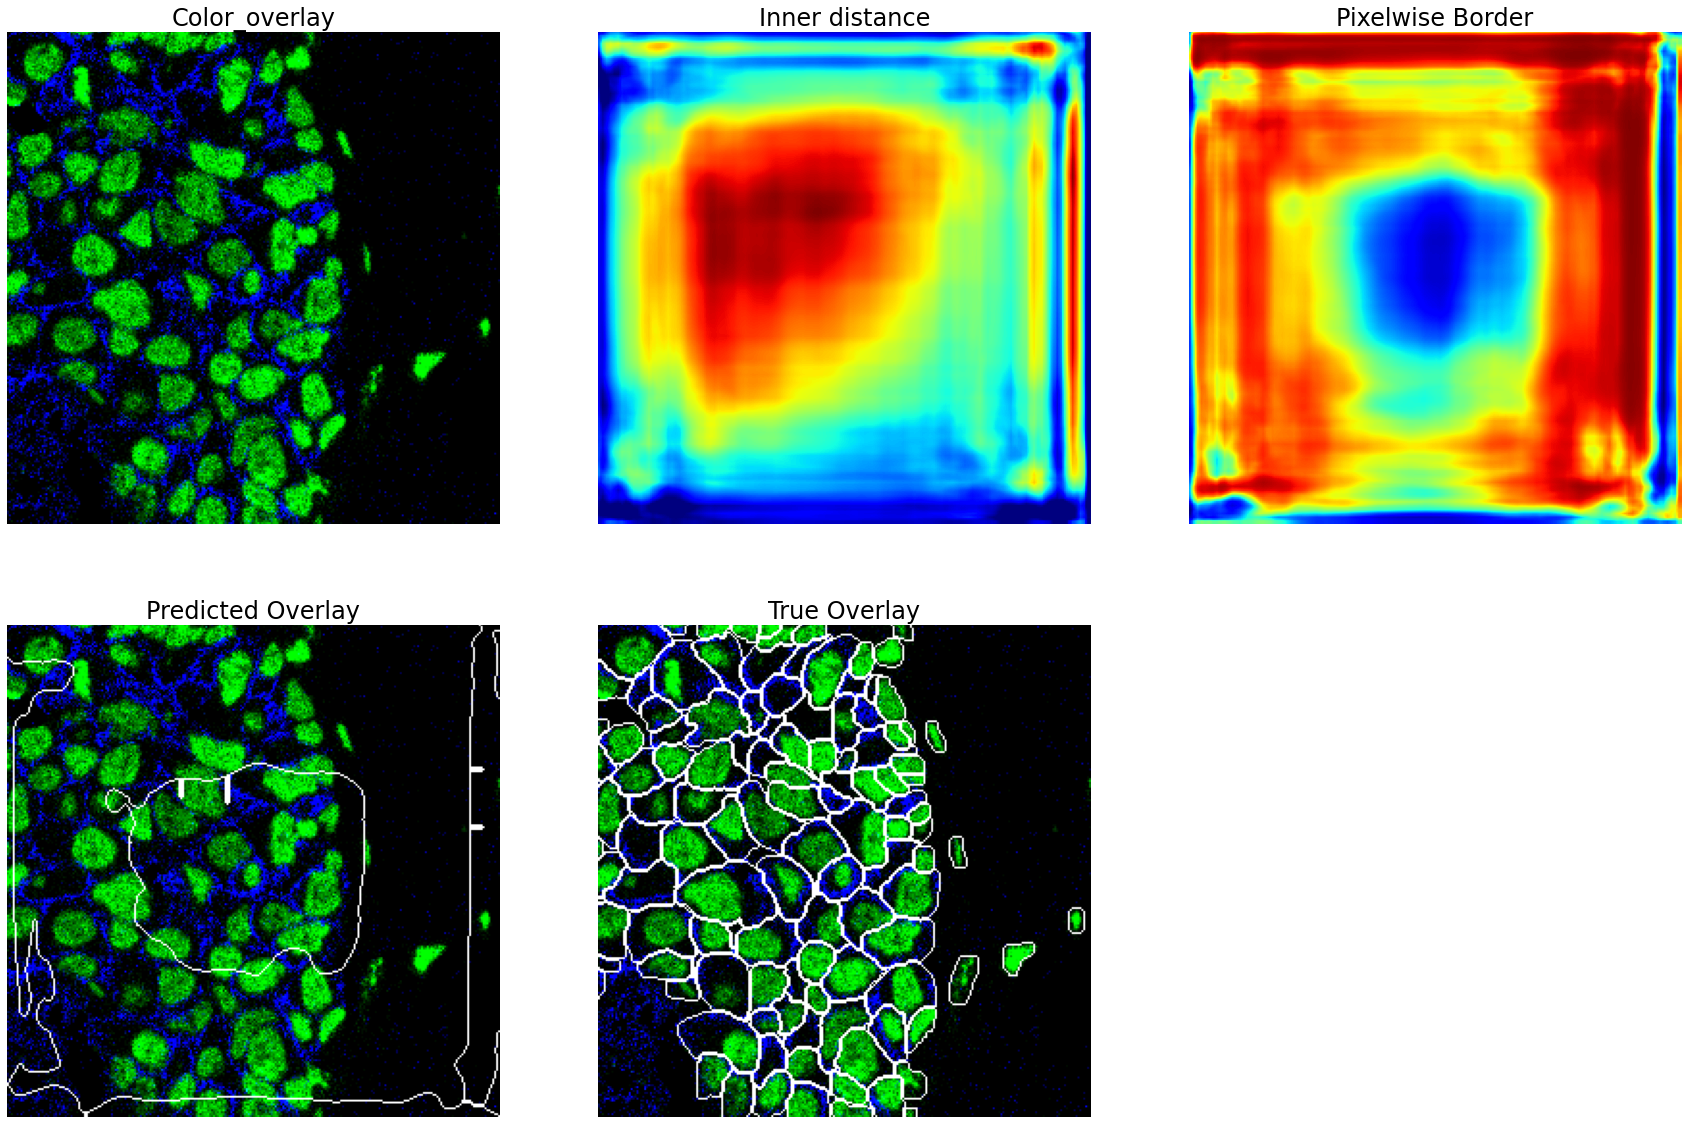

In [149]:
cmap = plt.get_cmap('viridis')
cmap.set_bad('black')
index = [0]
fig, axes = plt.subplots(2,3,figsize=(30,20))

axes = axes.flatten()
axes[0].imshow(RGB_data[index[0],...])
axes[1].imshow(inner_distance[index[0],...,0], cmap='jet')
axes[2].imshow(pixelwise[index[0],...,0], cmap='jet')
axes[3].imshow(predicted_overlay[index[0], ...], cmap=cmap)
axes[4].imshow(true_overlay[index[0], ...], cmap=cmap)

axes[0].set_title('Color_overlay', fontsize=24)
axes[1].set_title('Inner distance', fontsize=24)
axes[2].set_title('Pixelwise Border', fontsize=24)
axes[3].set_title('Predicted Overlay', fontsize=24)
axes[4].set_title('True Overlay', fontsize=24)
# axes[5].set_title('Ground Truth Mask', fontsize=24)

for ax in axes.flatten():
    ax.set_axis_off()